In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time

In [2]:
np.random.seed(99)

In [3]:
%run ./Lorenz_data.ipynb

N_washout = 100
N_train   = 10000
N_tstart  = 10000
N_test    = 5000

def gen_X_p(N_x, percentage, sigma_dyn = 1e-4, sigma_obs = 1e-4):
    """
    Generate data based on the number of nodes and the possibility of generating edges
    Half of the percentage are used for producing a_i,j = 1
    """
    rand = np.random.rand(N_x, N_x)
    A1 = (np.array(rand < (percentage / 2)).astype(int) + np.array(rand < percentage).astype(int)) / 2
    for i in range(N_x):
        A1[i,i] = 0

    if np.sum(A1==0) <= N_x:
        A1i, A1j = np.random.choice(N, 2, replace=False)
        A1[A1i, A1j] = 0
    if np.sum(A1==0.5) <= 0:
        A1i, A1j = np.random.choice(N, 2, replace=False)
        A1[A1i, A1j] = 0.5
    if np.sum(A1==1) <= 0:
        A1i, A1j = np.random.choice(N, 2, replace=False)
        A1[A1i, A1j] = 1

    X = gen_data_norm(N_x, A1, N_tstart+N_test, sigma_dyn = sigma_dyn, sigma_obs = sigma_obs)
    return X, A1

In [4]:
%run ./ESN.ipynb
%run ./Reconstruct.ipynb
%run ./Plot_TDI.ipynb

In [5]:
# network size
N_xs = [5,10,20]

# Probability of generating an edge
percentages = [0.5, 0.4, 0.25]

rep_times = 10

TDI_all = []
A_all = []
for nx in range(len(N_xs)):
    N_x = N_xs[nx]
    p = percentages[nx]
    
    TDI_x = []
    A_x = []
    for rep in range(rep_times):
        start = time.time()
        
        X, A = gen_X_p(N_x, p)
        A_x.append(A)

        # washout
        X_washout = X[:N_washout]
        # training
        X_t = X[N_washout:N_washout+N_train-1]
        Y_t = X[N_washout+1:N_washout+N_train]

        X_test = X[N_tstart:]

        seq = np.arange(N_x)
        variables = np.arange(N_x)+1

        N_dim   = 3 * N_x # dimension of inputs (and outputs)
        N_units = 100 * N_dim #units in the reservoir 

        N_net = 5
        TDInet = []

        N_rep, N_evo = 30, 10

        for net in range(N_net):
            esn = ESN(N_units, N_dim, N_dim)
            esn.train(X_washout, X_t, Y_t)

            TDInet.append(cal_TDI(esn, X_test, N_x, 3, 0, 1, N_rep, N_washout, N_evo))

        TDI = np.mean(np.array(TDInet), axis=0)
        TDI_x.append(TDI)
        
        print(f"current nx: {N_x}, rep:{rep}, time use:{time.time() - start}")
    A_all.append(A_x)
    TDI_all.append(TDI_x)

current nx: 5, rep:0, time use:79.22667741775513
current nx: 5, rep:1, time use:78.70316743850708
current nx: 5, rep:2, time use:77.38775944709778
current nx: 5, rep:3, time use:79.11644101142883
current nx: 5, rep:4, time use:78.26181936264038
current nx: 5, rep:5, time use:78.5226058959961
current nx: 5, rep:6, time use:78.16999506950378
current nx: 5, rep:7, time use:77.75829362869263
current nx: 5, rep:8, time use:78.6685562133789
current nx: 5, rep:9, time use:78.85708117485046
current nx: 10, rep:0, time use:791.6072995662689
current nx: 10, rep:1, time use:791.2349002361298
current nx: 10, rep:2, time use:796.5124423503876
current nx: 10, rep:3, time use:806.7933044433594
current nx: 10, rep:4, time use:795.9379782676697
current nx: 10, rep:5, time use:802.6425313949585
current nx: 10, rep:6, time use:792.5640280246735
current nx: 10, rep:7, time use:792.810525894165
current nx: 10, rep:8, time use:796.9352974891663
current nx: 10, rep:9, time use:787.5635468959808
current nx: 2

0.0010398930245485187 0.00014867372576014658
0.0006857661758530086 0.0001743167817747873
0.0012644811593859548 6.968477291982636e-05
0.0011285782176105902 0.00013155733526345784
0.0013748517472217821 5.986422446070218e-05
0.001249342842729997 7.178669628386453e-05
0.0009551058501779515 9.897113720283511e-05
0.0009847630487792975 4.246723459569712e-05
0.0011351948643659373 6.361137820859267e-05
0.0012008814406200773 5.84317063898176e-05


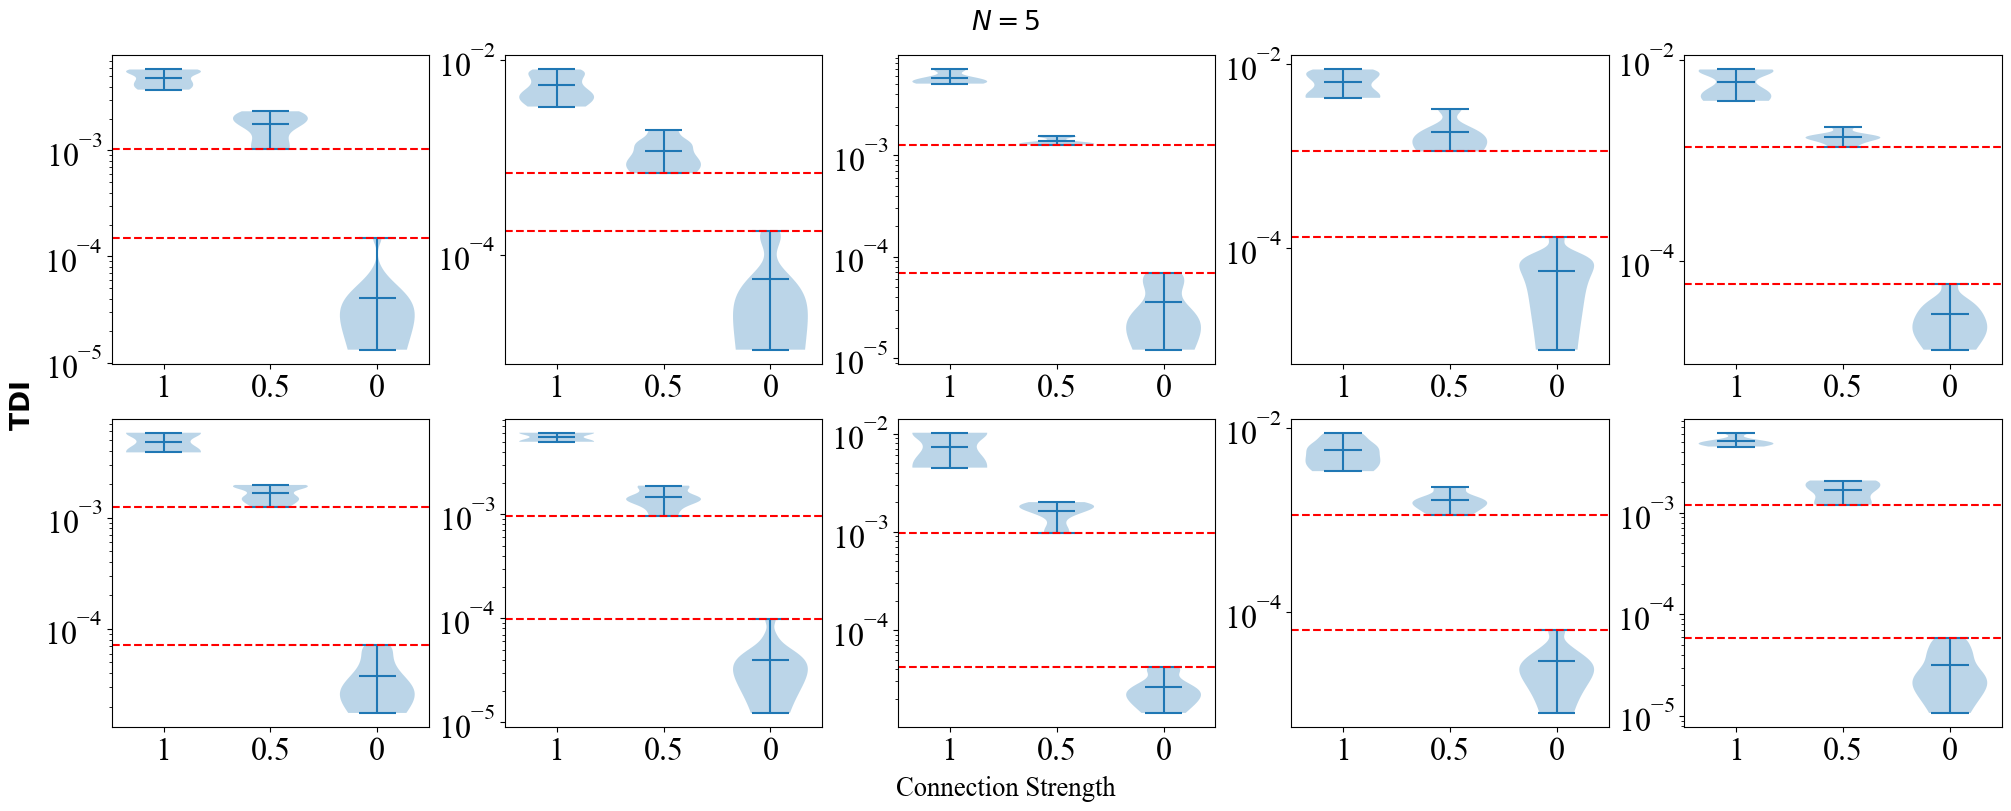

0.0007686615109497161 8.246311033252728e-05
0.0004450562489262613 0.00011971938861642808
0.0005407869615528927 0.0001249217896264365
0.0006136377627723142 0.00010016032821858671
0.0005295936272834703 0.00013096674296317166
0.0007141563999856304 9.331280279485856e-05
0.0005984285143726664 8.716441601653656e-05
0.0006981520065248414 0.00015082986264244465
0.00060737468738377 8.348310593511058e-05
0.0007308430796126158 0.00011621396650535732


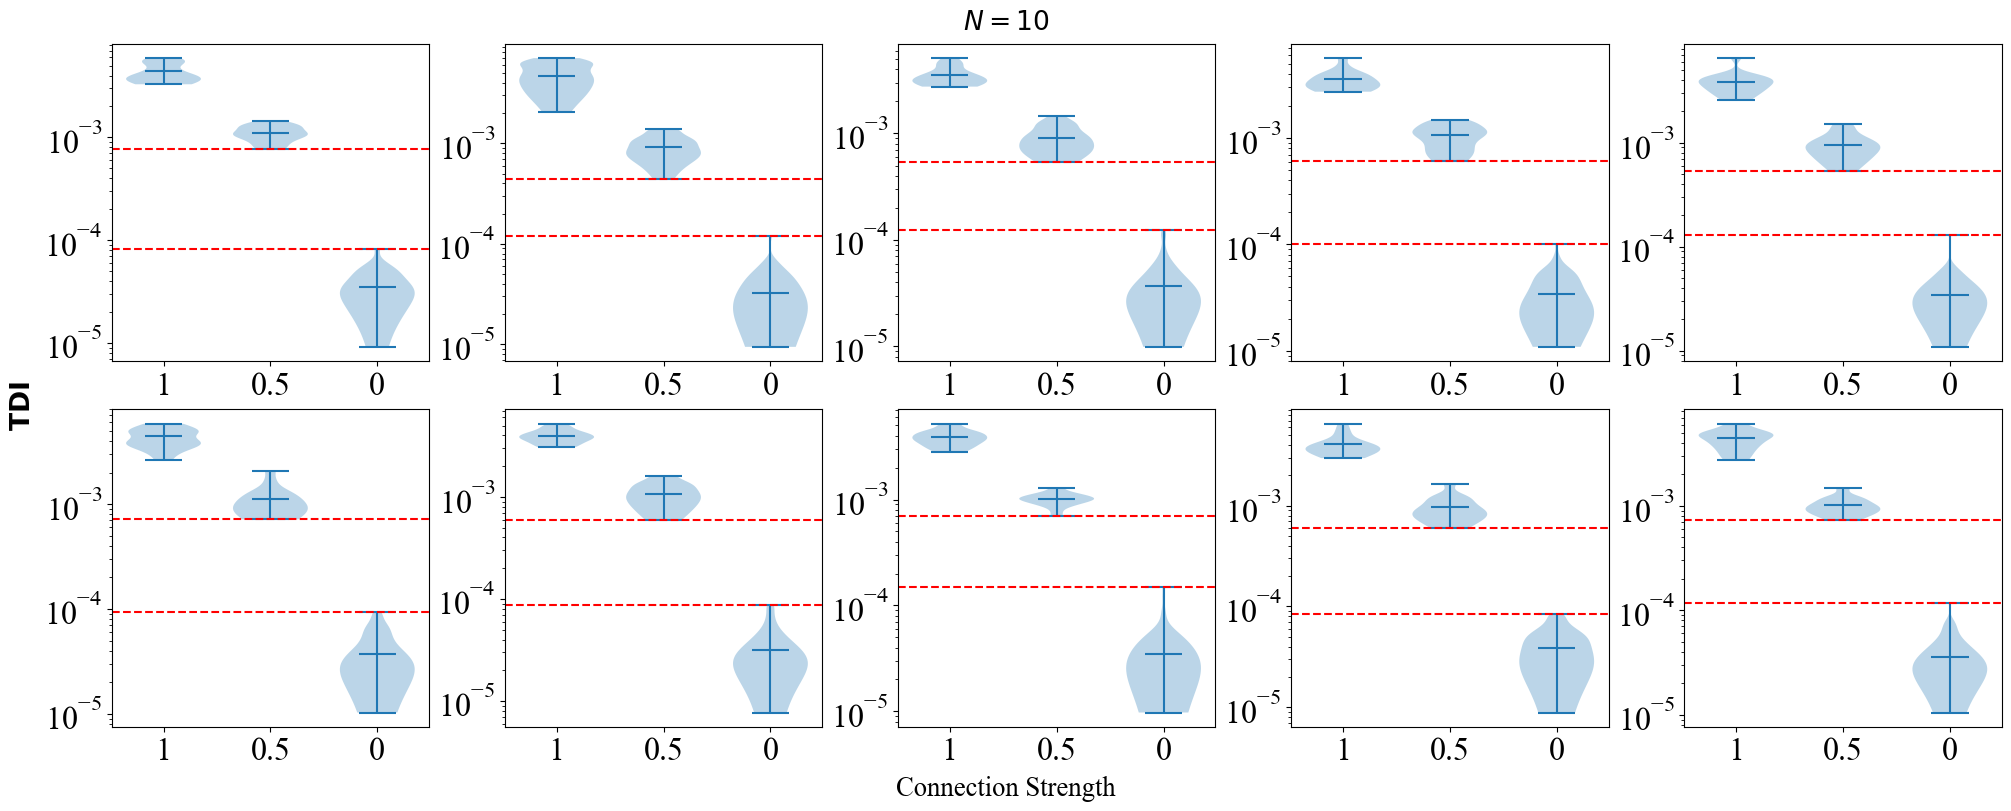

0.0002782762256283057 0.00018352791098980796
0.0003291581457767447 0.000215565130258922
0.00036367512029716247 0.00014592510300530823
0.000387490558981659 0.0001301650824006341
0.00033658111912992464 0.00015713947272769002
0.0002869606145711623 0.00014860099074764837
0.000333856993140252 0.00012340227664746182
0.0003069745999984845 0.00014279354136148965
0.00037551288938786456 0.00011059672811238664
0.0004066470762697068 0.00015142575478257055


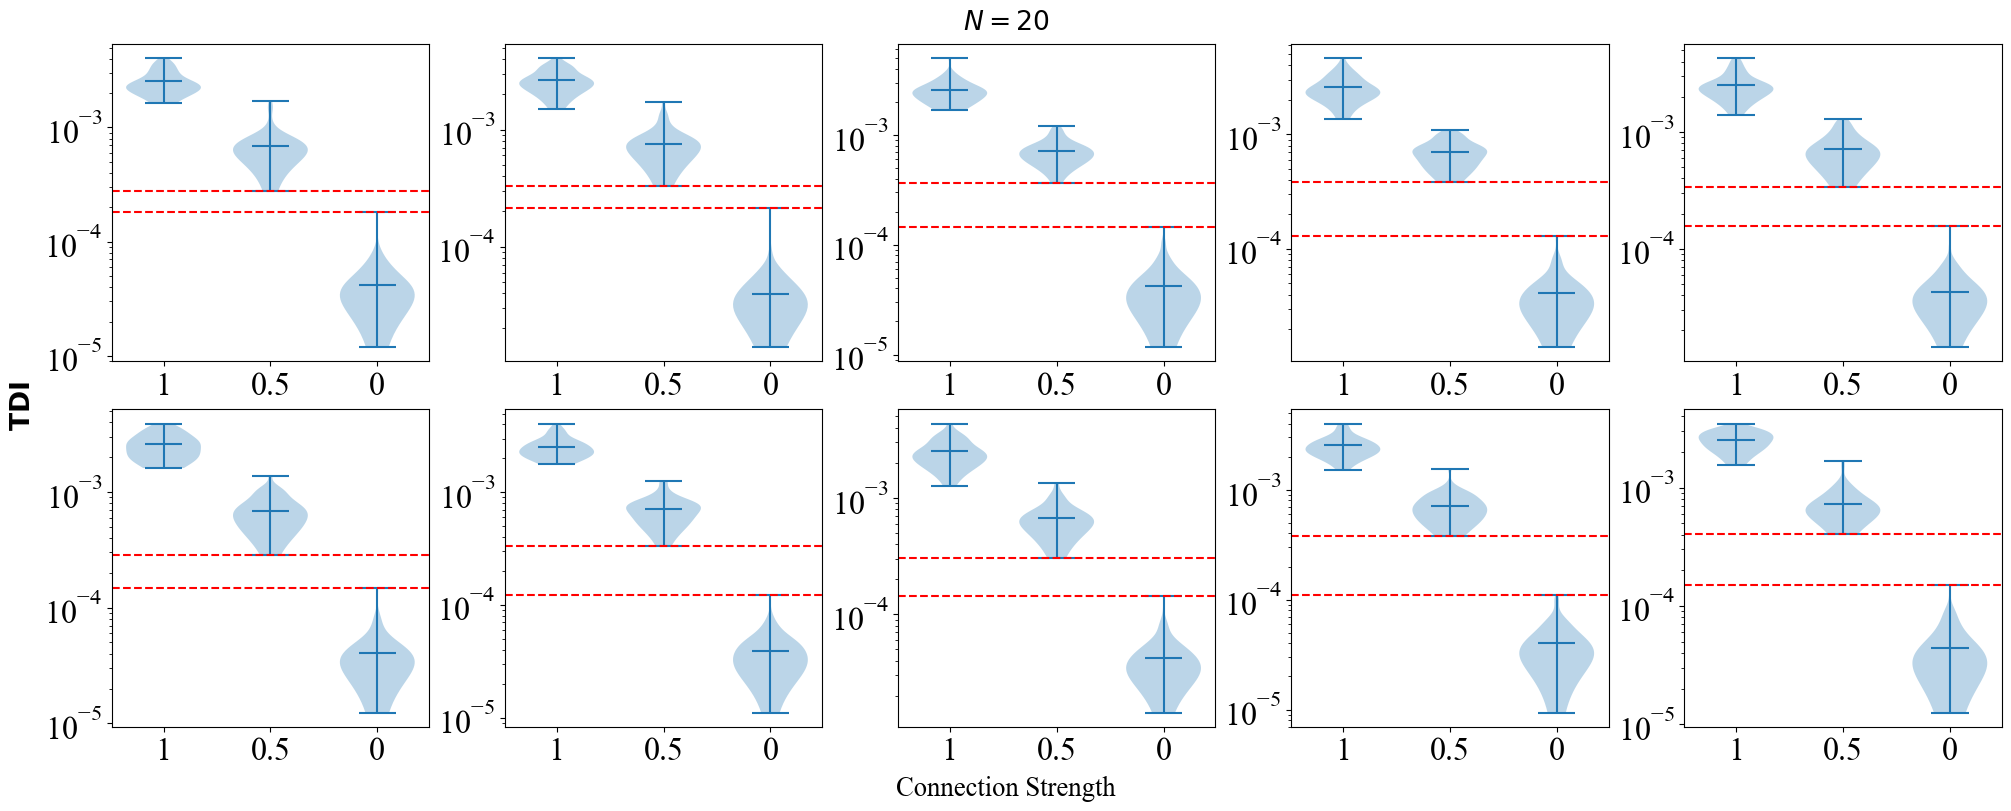

strength 1 data total count: 41
strength 0.5 data total count: 52
strength 0 data total count: 107
strength 1 data total count: 166
strength 0.5 data total count: 159
strength 0 data total count: 575
strength 1 data total count: 502
strength 0.5 data total count: 487
strength 0 data total count: 2811


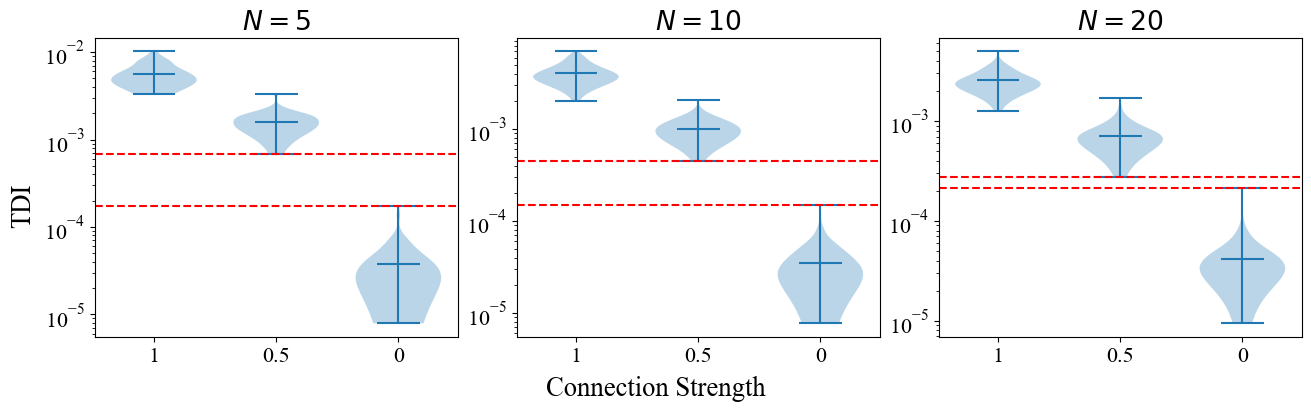

In [6]:
%run ./Plot_TDI.ipynb
plot_TDI_rep(A_all, TDI_all, [1, 0.5, 0])

In [8]:
# Executing T-test

strength_list = [1, 0.5, 0]

TDI_categorized = []
for _ in strength_list:
    TDI_categorized.append([])

for nx in range(len(N_xs)):
    print(f'size of causal network: {N_xs[nx]}')
    for rep in range(rep_times):
        A = A_all[nx][rep]
        TDI = TDI_all[nx][rep]

        for strength_index in range(len(strength_list)):
            xi,xj=np.where(A==strength_list[strength_index])
            for item in zip(xi,xj):
                if item[0] == item[1]:
                    continue
                TDI_categorized[strength_index] .append(TDI[item[0], item[1]])

    for pair in [[0,1], [0,2], [1,2]]:
        t_stat, p_value = stats.ttest_ind(TDI_categorized[pair[0]], TDI_categorized[pair[1]])
        print(f'p_value between connection strength {strength_list[pair[0]]} and {strength_list[pair[1]]}: {p_value:.2e}')

size of causal network: 5
p_value between connection strength 1 and 0.5: 2.92e-30
p_value between connection strength 1 and 0: 9.68e-74
p_value between connection strength 0.5 and 0: 7.26e-77
size of causal network: 10
p_value between connection strength 1 and 0.5: 2.15e-125
p_value between connection strength 1 and 0: 0.00e+00
p_value between connection strength 0.5 and 0: 0.00e+00
size of causal network: 20
p_value between connection strength 1 and 0.5: 9.53e-294
p_value between connection strength 1 and 0: 0.00e+00
p_value between connection strength 0.5 and 0: 0.00e+00
